# $E_{peak} - E_{iso}$ relation

In [110]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import erlang_gen

Correlation between $E_{peak}$ (spectral peak energy from $\nu F_\nu - \nu$ diagram) and $E_{iso}$ (equivalent isotropic energy).
Since the scatter plot is logarithmic, the correlation will be a power-law:
$$E_{peak} = m \cdot E_{iso}^q$$
where $m$ is the normalization factor and $q$ the slope.

The correlation can also be done between $E_{peak}$ and $E_\gamma$, which is the collimation-corrected energy, where $E_\gamma = E_{iso} \cdot (1 - cos\theta_{jet})$. Where $\theta_{jet}$ is derived with the bulk lorentz factor $\Gamma$ and the jet break time

In [131]:
df = pd.read_csv('table.csv') # read the data from Ghirlanda et al. 2008

In [132]:
for row in df.itertuples():
    print(row)

Pandas(Index=0, GRB='970228', z=0.695, α='−1.54', a_err=0.08, B='−2.5', B_err='0.4', Fluence='1.1e–5', Fluence_err='0.1e–5', Range='40–700', Epeak=195.0, Epeak_err=64.0, Eiso=1.6e+52, Eiso_err=1.2000000000000001e+51, Ref='1')
Pandas(Index=1, GRB='970508a', z=0.835, α='−1.71', a_err=0.1, B='−2.2', B_err='0.25', Fluence='1.8e–6', Fluence_err='0.3e–6', Range='40–700', Epeak=145.0, Epeak_err=43.0, Eiso=6.119999999999999e+51, Eiso_err=1.3e+51, Ref='1')
Pandas(Index=2, GRB='970828', z=0.958, α='−0.70', a_err=0.08, B='−2.1', B_err='0.4', Fluence='9.6e–5', Fluence_err='0.9e–5', Range='20–2000', Epeak=583.0, Epeak_err=117.0, Eiso=2.96e+53, Eiso_err=3.5e+52, Ref='2')
Pandas(Index=3, GRB='971214', z=3.42, α='−0.76', a_err=0.1, B='−2.7', B_err='1.1', Fluence='8.8e–6', Fluence_err='0.9e–6', Range='40–700', Epeak=685.0, Epeak_err=133.0, Eiso=2.11e+53, Eiso_err=2.4e+52, Ref='1')
Pandas(Index=4, GRB='980326', z=1.0, α='−1.23', a_err=0.21, B='−2.48', B_err='0.31', Fluence='7.5e–7', Fluence_err='1.5e–7'

In the readed data we can find the peak spectral energy $E_{peak}$ and the isotropic equivalent energy $E_{iso}$. Let's procede to create a scatter plot of both. First, we need to transform the `string` values fo $E_{\text{iso}}$ to `float`, and convert $\text{keV}$ to $\text{ergs} = \text{grcm}^2\text{s}^{-2}$ for $E_{\text{peak}}$.

In [137]:
def get_float(col):
    return np.array([float(base) * 10**float(exponent) for val in col for base, exponent in [str(val).split('e')]])

def kev_to_ergs(col):
    # 1 erg = 10**-3 * 6.242*10**11 keV
    return np.array([val*6.242*10**8 for val in col])

We can plot the data and then impose a `plt.loglog` scaling.

Text(0, 0.5, '$E_{\\text{peak}}\\ [\\text{keV}]$')

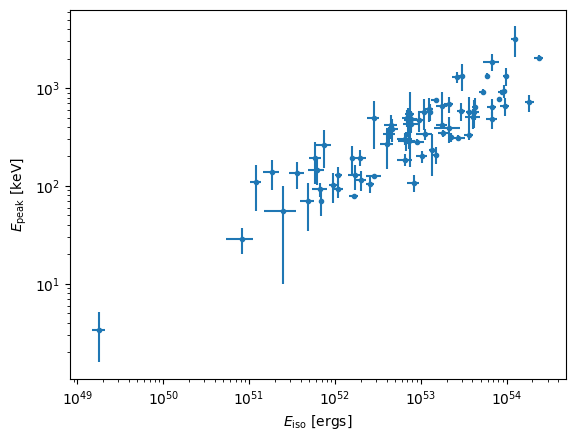

In [149]:
Epeak = kev_to_ergs(df['Epeak'])
Epeak_err = kev_to_ergs(df['Epeak_err'])

Eiso = get_float(df['Eiso'])
Eiso_err = get_float(df['Eiso_err'])

plt.figure()
plt.errorbar(Eiso, df['Epeak'], xerr=Eiso_err, yerr=df['Epeak_err'], fmt='.') # Epeak in keV
#plt.errorbar(Eiso, Epeak, xerr=Eiso_err, yerr=Epeak_err, fmt='.') # everything in ergs

plt.loglog()
plt.xlabel(r'$E_{\text{iso}}\ [\text{ergs}]$')
plt.ylabel(r'$E_{\text{peak}}\ [\text{keV}]$')

Or we can try to produce logarithmisiced lists of the data and plot those. Error propagation with logarithmic plots! In order to plot the error uncertainty of the magnitudes in both axis, we need to use the correct error propagation equation:
$$\sigma_{\text{log}} = \sigma_{\text{original}} / (\text{value} \cdot ln(10))$$

Text(0, 0.5, '$\\log(E_{\\text{iso}})$')

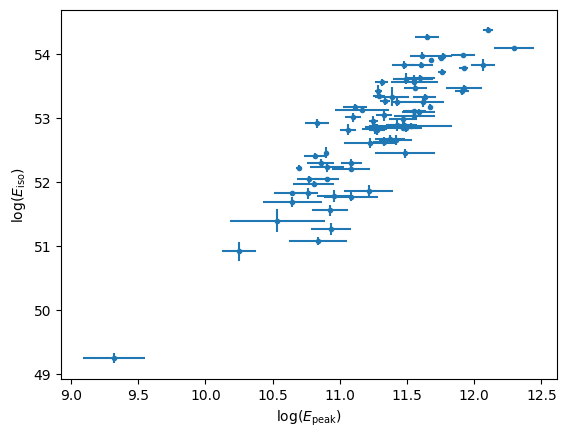

In [141]:
logEpeak = np.log10(Epeak)
logEpeak_err = Epeak_err / (Epeak * np.log(10)) # correct error propagation

logEiso = np.log10(Eiso)
logEiso_err = Eiso_err / (Eiso * np.log(10))

plt.figure()
plt.errorbar(logEiso, logEpeak, xerr=logEiso_err, yerr=logEpeak_err, fmt='.')
plt.xlabel(r'$\log(E_{\text{peak}})$')  # Fixed label
plt.ylabel(r'$\log(E_{\text{iso}})$')   # Fixed label

Next we'll try to find a fit for these GRB properties ($E_{\text{peak}}$ - $E_{\text{iso}}$). As explained above, this will be a power-law: $E_{\text{peak}} = m \cdot E_{\text{iso}}^q$. I will use a goodness of fit function (using the $\chi^2$ method and a parameter space $(m,q)$ to find the 'best fit'.

For the goodness of fit function we will use the $\chi^2$ method, following:
$$\chi^2 = \sum_{i=1} ^N \frac{\left(O_i - E_i \right)^2}{E_i^2}$$,
where $E_i$ and $O_i$ are the expected and observed values respectively.

In [151]:
def Gof(m,q,x=df['Eiso'], y=df['Epeak']): #TODO: for the moment, this GoF function does not take the errors into account
    """
    Goodness of fit following the chi-squared formula
    :param m: normalization factor of power-law
    :param q: slope of power-law
    :param x: x-values
    :param y: y-values
    :return: sum of chi-squared error
    """

    model = m*x**q
    chi_squared = []
    for i in range(len(x)):
        val = ((y[i] - model[i])**2)/model[i]
        chi_squared.append(val)

    return np.sum(chi_squared)

As there were some errors with the plotting of the GoF results, I'll go safe with the method employed in [intropython](https://github.com/omsharansalafia/intropython/blob/main/notes/05_ModelFitting.ipynb), i.e. the least squares error:

In [164]:
def GoF(m, q, x=df['Eiso'], y=df['Epeak']):
    """
    Goodness of fit following the "least squares" method.
    :param m: parameter 1 (normalization factor)
    :param q: parameter 2 (slope of power-law)
    :param x: x-values
    :param y: y-values
    :return:
    """

    model = m*x+q
    squares = (model-y)**2
    return np.sum(squares)

Next, I create the (m, q) parameter space and create a $\chi^2(m, q)$ surface plot.

(array([[-6.81145799e+60, -5.50482891e+59, -4.44957719e+58, ...,
         -6.65217535e+53, -8.11571268e+54, -9.90579400e+55],
        [-6.95190043e+60, -5.61833054e+59, -4.54132105e+58, ...,
         -6.51778797e+53, -7.95175888e+54, -9.70567695e+55],
        [-7.09825622e+60, -5.73661118e+59, -4.63692780e+58, ...,
         -6.38340059e+53, -7.78780509e+54, -9.50555990e+55],
        ...,
        [ 7.09825622e+60,  5.73661118e+59,  4.63692780e+58, ...,
          6.38340059e+53,  7.78780509e+54,  9.50555990e+55],
        [ 6.95190043e+60,  5.61833054e+59,  4.54132105e+58, ...,
          6.51778797e+53,  7.95175888e+54,  9.70567695e+55],
        [ 6.81145799e+60,  5.50482891e+59,  4.44957719e+58, ...,
          6.65217535e+53,  8.11571268e+54,  9.90579400e+55]],
       shape=(100, 100)),
 <Figure size 640x480 with 2 Axes>)

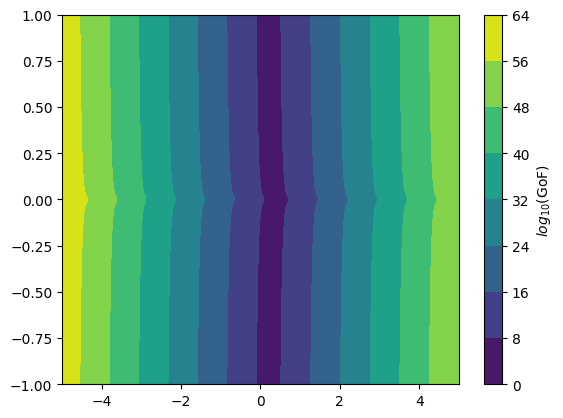

In [169]:
m = np.linspace(-5., 5., 100)
q = np.linspace(-1., 1., 100)

def run_GoF(m, q):
    """
    Returns the results of runing the parameter space through GoF and the plot of it.
    :param m: parameter 1 (normalization factor)
    :param q: parameter 2 (power-law slope)
    :return: G [len(m), len(q)] array for GoF results, plt.figure
    """
    G = np.zeros([len(m), len(q)])
    for i in range(len(m)):
        for j in range(len(q)):
            G[i][j] = Gof(m[i], q[j])

    fig = plt.figure()
    plt.contourf(m, q, np.log10(np.abs(G))) #absolute values #TODO: this is surely not how its done
    plt.colorbar(label=r'$log_{10}(\text{GoF})$')

    return G, fig

run_GoF(m,q)

To get the best fit, we will explore other boudns for the parameter space.

/var/folders/lq/7_q5kjhn1pzgzvpl0fk8y5mc0000gp/T/ipykernel_7111/789521158.py:17: RuntimeWarning: invalid value encountered in log10
  plt.contourf(m,q,np.log10(G))


(array([[-3.40572900e+60, -2.75241446e+59, -2.22478859e+58, ...,
         -1.33043507e+54, -1.62314254e+55, -1.98115880e+56],
        [-3.47595021e+60, -2.80916527e+59, -2.27066052e+58, ...,
         -1.30355759e+54, -1.59035178e+55, -1.94113539e+56],
        [-3.54912811e+60, -2.86830559e+59, -2.31846390e+58, ...,
         -1.27668012e+54, -1.55756102e+55, -1.90111198e+56],
        ...,
        [ 3.54912811e+60,  2.86830559e+59,  2.31846390e+58, ...,
          1.27668012e+54,  1.55756102e+55,  1.90111198e+56],
        [ 3.47595021e+60,  2.80916527e+59,  2.27066052e+58, ...,
          1.30355759e+54,  1.59035178e+55,  1.94113539e+56],
        [ 3.40572900e+60,  2.75241446e+59,  2.22478859e+58, ...,
          1.33043507e+54,  1.62314254e+55,  1.98115880e+56]],
       shape=(100, 100)),
 <Figure size 640x480 with 2 Axes>)

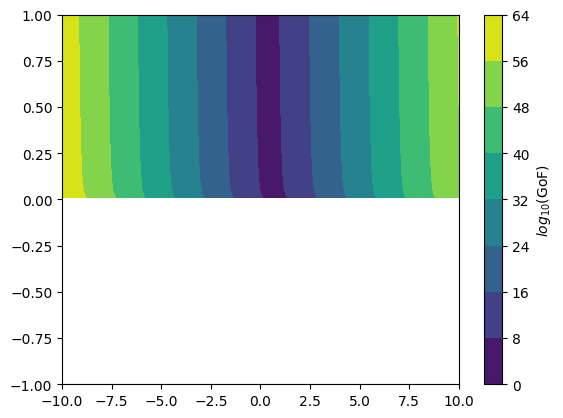

In [163]:
m = np.linspace(-10., 10., 100)
q = np.linspace(-1., 1., 100)

run_GoF(m,q)

In [ ]:
,